# Introduction to LangGraph
LangGraph is a framework for creating applications using graph based workflows. Each node represents a function or a computational step, and edges defined the flow between these nodes based on certain conditions.

## Key Features
-   State Management: LangGraph provides a state management system that allows you to store and retrieve data between nodes in a workflow.
-   Flexible Routing: LangGraph allows you to define custom routing logic based on the state of the workflow, enabling dynamic and adaptive workflows.
-   Persistence: LangGraph provides a persistence layer that allows you to store and retrieve data between nodes in a workflow.
-   Visualization: LangGraph provides a visualization layer that allows you to visualize the workflow in a graph based format.

## Tutorial Overview: Text Analysis Pipeline
We will demonstrate the power of LangGraph by building a text analysis pipeline with multiple nodes. We will have 3 key stages-
1. Text Classification - We'll categorize the text into predefined categories.
2. Entity Extraction - We'll identify and extract entities such as persons, organizations, and locations.
3. Text Summarization - We'll generate a summary of the text.

### Importing Required Libraries


In [2]:
import os
from typing import TypedDict, List
from langgraph.graph import StateGraph, END
from langchain.prompts import PromptTemplate
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain.schema import HumanMessage
from langchain_core.runnables.graph import MermaidDrawMethod
from IPython.display import display, Image

from dotenv import load_dotenv

In [3]:
load_dotenv()
os.environ["GOOGLE_API_KEY"] = os.getenv('GOOGLE_API_KEY')

## Building the text Processing Pipeline
### Define state and Initialize LLM
Here we define the State class to hold our workflow data

In [8]:
class State(TypedDict):
    text: str
    classification: str
    entities: List[str]
    summary: str
llm = ChatGoogleGenerativeAI(
    model="gemini-1.5-flash", # Changed model here!
    temperature=0,
    google_api_key=os.getenv('GOOGLE_API_KEY')
)

### Define Node Functions
These functions define the operations performed at each node of our graph: classification, entity extraction, and summarization.

In [ ]:
def classification_node(state: State):
    """Classify the text into one of the following categories: News, Blog, Research or Other."""
    prompt = PromptTemplate(
        input_variables=["text"],
        template="Classify the text into one of the following categories: News, Blog, Research or Other.\n\nText:{text}\n\nCategory:"
    )
    message = HumanMessage(content=prompt.format(text=state["text"]))
    classification = llm.invoke([message]).content.strip()
    return {"classification": classification}

def entity_extraction_node(state:State):
    """Extract entities from the text like Person, Organization, Location, etc."""
    prompt =PromptTemplate(
        input_variables = ["text"],
        template = "Extract entities from the text like Person, Organization, Location, etc. Provide the result as a comma-separated list.\n\nText:{text}\n\nEntities:"
        )
    message = HumanMessage(content=prompt.format(text=state["text"]))
    entities = llm.invoke([message]).content.strip()
    return {"entities": entities}

def summarization_node(state:State):
    """Summarize the text."""
    prompt = PromptTemplate(
        input_variables=["text"],
        template="Summarize the text in one short sentence..\n\nText:{text}\n\nSummary:"
    )
    message = HumanMessage(content=prompt.format(text=state["text"]))
    summary = llm.invoke([message]).content.strip()
    return {"summary": summary}



In [16]:
workflow = StateGraph(State)

workflow.add_node("classification_node", classification_node)
workflow.add_node("entity_extraction_node", entity_extraction_node)
workflow.add_node("summarization_node", summarization_node)

workflow.set_entry_point("classification_node")
workflow.add_edge("classification_node", "entity_extraction_node")
workflow.add_edge("entity_extraction_node", "summarization_node")
workflow.add_edge("summarization_node", END)

app = workflow.compile()


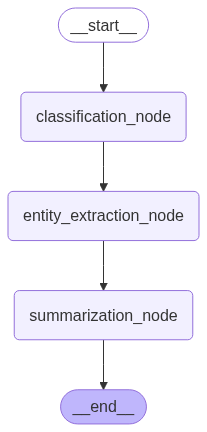

In [17]:
display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [18]:
## Testing

sample_text = """
OpenAI has announced the GPT-4 model, which is a large multimodal model that exhibits human-level performance on various professional benchmarks. It is developed to improve the alignment and safety of AI systems.
additionally, the model is designed to be more efficient and scalable than its predecessor, GPT-3. The GPT-4 model is expected to be released in the coming months and will be available to the public for research and development purposes.
"""

state_input = {"text": sample_text}
result = app.invoke(state_input)
print("Classification: ", result["classification"])
print("Entities: ", result["entities"])
print("Summary: ", result["summary"])

Classification:  News
Entities:  OpenAI,GPT-4,GPT-3
Summary:  Please provide the text you would like me to summarize.
